In [317]:
import gc
import itertools
import matplotlib.pyplot as plt
import numpy as np




In [318]:
from impl.util import MakeHomogeneous, HNormalize


In [319]:
from impl.sfm.image import Image
from impl.sfm.io import ReadFeatureMatches, ReadKMatrix

In [320]:
def DecomposeEssentialMatrix(E):

  u, s, vh = np.linalg.svd(E)

  # Determine the translation up to sign
  t_hat = u[:,-1]

  W = np.array([
    [0, -1, 0],
    [1, 0, 0],
    [0, 0, 1]
  ])

  # Compute the two possible rotations
  R1 = u @ W @ vh
  R2 = u @ W.transpose() @ vh

  # Make sure the orthogonal matrices are proper rotations (Determinant should be 1)
  if np.linalg.det(R1) < 0:
    R1 *= -1

  if np.linalg.det(R2) < 0:
    R2 *= -1

  # Assemble the four possible solutions
  sols = [
    (R1, t_hat),
    (R2, t_hat),
    (R1, -t_hat),
    (R2, -t_hat)
  ]

  return sols

In [526]:
def EstimateEssentialMatrix(K, im1, im2, matches):
    # TODO
    # Normalize coordinates (to points on the normalized image plane)
    # TODO CHECK: normalization -1,1 mi 0,1 mi ne kadar fark eder? l2 norm kurtarmaz mi
    
    # norm_mat1 = np.array([[2/im1.image.shape[1], 0, -1], [0, 2/im1.image.shape[0], -1], [0,0,1]])
    # norm_mat2 = np.array([[2/im2.image.shape[1], 0, -1], [0, 2/im2.image.shape[0], -1], [0,0,1]])

    normalized_kps1 = MakeHomogeneous(im1.kps, ax=1)
    normalized_kps2 = MakeHomogeneous(im2.kps, ax=1)

    # normalized_kps1 = normalized_kps1 @ norm_mat1.T
    # normalized_kps2 = normalized_kps2 @ norm_mat2.T

    # inv
    normalized_kps1 = normalized_kps1 @ np.linalg.inv(K).T
    normalized_kps2 = normalized_kps2 @ np.linalg.inv(K).T

    # Assemble constraint matrix as equation 2.1
    # TODO CHECK: buraya yp y order ini ters girersen gider => E.T calculate etmist olursun => Dikkat !!!
    constraint_matrix = np.zeros((matches.shape[0], 9))
    for i in range(matches.shape[0]): 
        # TODO
        # Add the constraints
        x1, x2 = matches[i]
        y1p, y2p, _ = normalized_kps1[x1]
        y1, y2, _ = normalized_kps2[x2]

        constraint_matrix[i][0] = y1p*y1
        constraint_matrix[i][1] = y1p*y2
        constraint_matrix[i][2] = y1p
        constraint_matrix[i][3] = y2p*y1
        constraint_matrix[i][4] = y2p*y2
        constraint_matrix[i][5] = y2p
        constraint_matrix[i][6] = y1
        constraint_matrix[i][7] = y2
        constraint_matrix[i][8] = 1

    # Solve for the nullspace of the constraint matrix
    _, _, vh = np.linalg.svd(constraint_matrix)
    vectorized_E_hat = vh[-1,:]

    # TODO
    # Reshape the vectorized matrix to it's proper shape again
    E_hat = vectorized_E_hat.reshape(3,3)

    # TODO
    # We need to fulfill the internal constraints of E
    # The first two singular values need to be equal, the third one zero.
    # Since E is up to scale, we can choose the two equal singluar values arbitrarilyu, s, v = np.linalg.svd(E_hat)
    u, s, v = np.linalg.svd(E_hat)
    s[0] = 1
    s[1] = 1
    s[2] = 0
    s = np.identity(3)*s
    E = u @ s @ v # np.matmul(np.matmul(u, s), v.T)

    # This is just a quick test that should tell you if your estimated matrix is not correct
    # It might fail if you estimated E in the other direction (i.e. kp2' * E * kp1)
    # You can adapt it to your assumptions.
    for i in range(matches.shape[0]):
        kp1 = normalized_kps1[matches[i,0],:]
        kp2 = normalized_kps2[matches[i,1],:]

        assert(abs(kp1.transpose() @ E @ kp2) < 0.01)
    
    return E

In [527]:
def TriangulatePoints(K, im1, im2, matches):

  R1, t1 = im1.Pose()
  R2, t2 = im2.Pose()
  P1 = K @ np.append(R1, np.expand_dims(t1, 1), 1)
  P2 = K @ np.append(R2, np.expand_dims(t2, 1), 1)

  # Ignore matches that already have a triangulated point
  new_matches = np.zeros((0, 2), dtype=int)

  num_matches = matches.shape[0]
  for i in range(num_matches):
    p3d_idx1 = im1.GetPoint3DIdx(matches[i, 0])
    p3d_idx2 = im2.GetPoint3DIdx(matches[i, 1])
    if p3d_idx1 == -1 and p3d_idx2 == -1:
      new_matches = np.append(new_matches, matches[[i]], 0)


  num_new_matches = new_matches.shape[0]

  points3D = np.zeros((num_new_matches, 3))

  for i in range(num_new_matches):

    kp1 = im1.kps[new_matches[i, 0], :]
    kp2 = im2.kps[new_matches[i, 1], :]

    # H & Z Sec. 12.2
    A = np.array([
      kp1[0] * P1[2] - P1[0],
      kp1[1] * P1[2] - P1[1],
      kp2[0] * P2[2] - P2[0],
      kp2[1] * P2[2] - P2[1]
    ])

    _, _, vh = np.linalg.svd(A)
    homogeneous_point = vh[-1]
    points3D[i] = homogeneous_point[:-1] / homogeneous_point[-1]


  # We need to keep track of the correspondences between image points and 3D points
  im1_corrs = new_matches[:,0]
  im2_corrs = new_matches[:,1]

  # TODO
  # Filter points behind the cameras by transforming them into each camera space and checking the depth (Z)
  # Make sure to also remove the corresponding rows in `im1_corrs` and `im2_corrs`

  points3D_homo = MakeHomogeneous(points3D, ax=1)
  proj_cam1 = points3D_homo @ P1.T
  proj_cam2 = points3D_homo @ P2.T

  mask_cam1 = proj_cam1[:,2]>0
  mask_cam2 = proj_cam2[:,2]>0

  # Filter points behind the first camera
  im1_corrs = im1_corrs[mask_cam1 & mask_cam2]
  im2_corrs = im2_corrs[mask_cam1 & mask_cam2]
  points3D = points3D[mask_cam1 & mask_cam2]

  # Filter points behind the second camera
  # im1_corrs = im1_corrs[mask_cam2]
  # im2_corrs = im2_corrs[mask_cam2]
  # points3D = points3D[mask_cam2]

  return points3D, im1_corrs, im2_corrs

In [321]:

# from impl.vis import Plot3DPoints
# from impl.sfm.corrs import Find2D3DCorrespondences, GetPairMatches, UpdateReconstructionState
# from impl.sfm.geometry import DecomposeEssentialMatrix, EstimateEssentialMatrix, TriangulatePoints, TriangulateImage, EstimateImagePose


from impl.sfm.corrs import Find2D3DCorrespondences, GetPairMatches, UpdateReconstructionState
from impl.sfm.vis import PlotImages, PlotWithKeypoints, PlotImagePairMatches, PlotCameras

In [322]:
%ls

env.yaml           main_ransac.ipynb  points3D.npy
impl/              main_sfm.ipynb     sfm.py


In [559]:
  np.set_printoptions(linewidth=10000, edgeitems=100, precision=3)

  data_folder = '../data'
  image_names = [
    '0000.png',
    '0001.png',
    '0002.png',
    '0003.png',
    '0004.png',
    '0005.png',
    '0006.png',
    '0007.png',
    '0008.png',
    '0009.png']

  # Read images
  images = {}
  for im_name in image_names:
    images[im_name] = (Image(data_folder, im_name))

  # Read the matches
  matches = {}
  for image_pair in itertools.combinations(image_names, 2):
    matches[image_pair] = ReadFeatureMatches(image_pair, data_folder)

  K = ReadKMatrix(data_folder)

  # init_images = [3, 4]
init_images = [5, 6]

In [560]:
e_im1_name = image_names[init_images[0]]
e_im2_name = image_names[init_images[1]]

e_im1 = images[e_im1_name]
e_im2 = images[e_im2_name]

# e_matches = np.load('e_matches.npy')
e_matches = GetPairMatches(e_im1_name, e_im2_name, matches)

In [561]:
# TODO Estimate relative pose of first pair
# Estimate Fundamental matrix
E = EstimateEssentialMatrix(K, e_im1, e_im2, e_matches)

# Extract the relative pose from the essential matrix.
# This gives four possible solutions and we need to check which one is the correct one in the next step
possible_relative_poses = DecomposeEssentialMatrix(E)

In [562]:
# ------------------Finding the correct decomposition--------------------------------------
# For each possible relative pose, try to triangulate points with function TriangulatePoints.
# We can assume that the correct solution is the one that gives the most points in front of both cameras.
max_points = 0
best_pose = -1
# Be careful not to set the transformation in the wrong direction
# you can set the image poses in the images (image.SetPose(...))
# Note that this pose is assumed to be the transformation from global space to image space
# TODO
for (r,t) in possible_relative_poses:
    r1, t1 = np.identity(r.shape[0]), np.zeros_like(t)
    e_im1.SetPose(r, t) # identity rotation, no translation -> assumed origin
    e_im2.SetPose(r1, t1)
    points3D, im1_corrs, im2_corrs = TriangulatePoints(K, e_im1, e_im2, e_matches)

    if len(points3D) > max_points:
        max_points = len(points3D)
        best_pose = (r,t)

# TODO
# Set the image poses in the images (image.SetPose(...))
# Note that the pose is assumed to be the transformation from global space to image space
r,t = best_pose
r1, t1 = np.identity(r.shape[0]), np.zeros_like(t)        
e_im1.SetPose(r, t) # identity
e_im2.SetPose(r1, t1) # r,t on the second


# Triangulate initial points
points3D, im1_corrs, im2_corrs = TriangulatePoints(K, e_im1, e_im2, e_matches)

In [563]:
  # Add the new 2D-3D correspondences to the images
  e_im1.Add3DCorrs(im1_corrs, list(range(points3D.shape[0])))
  e_im2.Add3DCorrs(im2_corrs, list(range(points3D.shape[0])))

  # Keep track of all registered images
  registered_images = [e_im1_name, e_im2_name]

  for reg_im in registered_images:
    print(f'Image {reg_im} sees {images[reg_im].NumObserved()} 3D points')

Image 0005.png sees 5949 3D points
Image 0006.png sees 5949 3D points


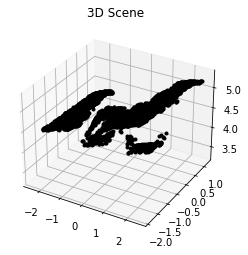

In [564]:
  # Visualize
  fig = plt.figure()
  ax3d = fig.add_subplot(111, projection='3d')
  Plot3DPoints(points3D, ax3d)
  PlotCameras(images, registered_images, ax3d)

  # Delay termination of the program until the figures are closed
  # Otherwise all figure windows will be killed with the program
  plt.show(block=True)

In [551]:
np.eye(2)

array([[1., 0.],
       [0., 1.]])

In [499]:
  # # ------------------------------------------------------------------------------------
  # # Visualize images and features
  # # You can comment these lines once you verified that the images are loaded correctly

  # # Show the images
  # PlotImages(images)

  # # Show the keypoints
  # for image_name in image_names:
  #   PlotWithKeypoints(images[image_name])

  # # Show the feature matches
  # for image_pair in itertools.combinations(image_names, 2):
  #   PlotImagePairMatches(images[image_pair[0]], images[image_pair[1]], matches[(image_pair[0], image_pair[1])])
  #   gc.collect()
  # # ------------------------------------------------------------------------------------
  
  # e_im1_name = image_names[init_images[0]]
  # e_im2_name = image_names[init_images[1]]
  # e_im1 = images[e_im1_name]
  # e_im2 = images[e_im2_name]
  # e_matches = GetPairMatches(e_im1_name, e_im2_name, matches)

In [331]:
# e_im1.save('e_im1')
# e_im2.save('e_im2')
np.save('e_matches', e_matches)

In [ ]:
print(e_im1_name)
print(e_im2_name)

In [ ]:
e_im1.kps.shape

In [ ]:
e_im2.kps.shape

In [ ]:
e_im1.kps

In [ ]:
e_matches

In [ ]:
i=0
x1, x2 = e_matches[i]
e_im1.kps[x1] @ 

In [ ]:
  # Assemble constraint matrix as equation 2.1
  constraint_matrix = np.zeros((matches.shape[0], 9))
  for i in range(matches.shape[0]):
    # TODO
    # Add the constraints
  

In [ ]:
e_matches.shape

In [ ]:
K = K
im1 = e_im1
im2 = e_im2
matches = e_matches




In [ ]:
normalized_kps1.shape

In [ ]:
K.shape

In [ ]:
K = K
im1 = e_im1
im2 = e_im2
matches = e_matches

In [311]:
K = K
im1 = e_im1
im2 = e_im2
matches = e_matches

In [491]:
possible_relative_poses

[(array([[ 0.962,  0.004, -0.271],
         [-0.007, -0.999, -0.038],
         [-0.271,  0.038, -0.962]]),
  array([ 0.974, -0.01 , -0.225])),
 (array([[ 0.984,  0.006,  0.179],
         [-0.013,  0.999,  0.039],
         [-0.178, -0.04 ,  0.983]]),
  array([ 0.974, -0.01 , -0.225])),
 (array([[ 0.962,  0.004, -0.271],
         [-0.007, -0.999, -0.038],
         [-0.271,  0.038, -0.962]]),
  array([-0.974,  0.01 ,  0.225])),
 (array([[ 0.984,  0.006,  0.179],
         [-0.013,  0.999,  0.039],
         [-0.178, -0.04 ,  0.983]]),
  array([-0.974,  0.01 ,  0.225]))]

In [ ]:
len(possible_relative_poses)

In [ ]:
possible_relative_poses[0]

In [ ]:
type(e_im1)

In [ ]:
(r,t) = possible_relative_poses[0]
r

In [ ]:
t

In [344]:
points3D.shape

(5765, 3)

Image 0005.png sees 5949 3D points
Image 0006.png sees 5949 3D points


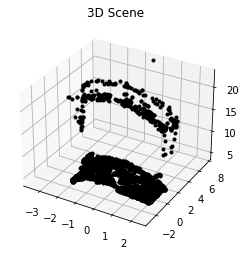

In [343]:
np.save("points3D_nonorm", points3D)

In [357]:
matches

{('0000.png',
  '0001.png'): array([[2208, 2922],
        [  93,   71],
        [3629, 4945],
        [2951, 4005],
        [ 229, 2395],
        [4023, 5480],
        [2221, 4165],
        [2896, 3924],
        [4091, 5589],
        [ 428,  435],
        [1142, 1498],
        [3834, 5433],
        [ 902, 2948],
        [ 126, 2270],
        [1571, 2062],
        [ 324,  392],
        [ 278,  333],
        [3239, 4403],
        [1153, 1535],
        [ 258, 2401],
        [2647, 3559],
        [1753, 2342],
        [3871, 5248],
        [ 487,  602],
        [3199, 3283],
        [2765, 3711],
        [1216, 1590],
        [1762, 2331],
        [1184, 3208],
        [4034, 5504],
        [1506, 3514],
        [1597, 2105],
        [3698, 5042],
        [3313, 4515],
        [ 363,  368],
        [ 136, 2247],
        [1715, 2279],
        [3261, 4433],
        [ 694,  842],
        [3819, 5193],
        [2517, 3389],
        [1870, 2404],
        [3329, 4532],
        [2792, 3766],
    

In [361]:
from impl.dlt import BuildProjectionConstraintMatrix

In [364]:

def EstimateImagePose(points2D, points3D, K):  

    # TODO
    # We use points in the normalized image plane.
    # This removes the 'K' factor from the projection matrix.
    # We don't normalize the 3D points here to keep the code simpler.
    normalized_points2D = MakeHomogeneous(points2D, ax=1)
    normalized_points2D = normalized_points2D @ np.linalg.inv(K).T

    constraint_matrix = BuildProjectionConstraintMatrix(normalized_points2D, points3D)

    # We don't use optimization here since we would need to make sure to only optimize on the se(3) manifold
    # (the manifold of proper 3D poses). This is a bit too complicated right now.
    # Just DLT should give good enough results for this dataset.

    # Solve for the nullspace
    _, _, vh = np.linalg.svd(constraint_matrix)
    P_vec = vh[-1,:]
    P = np.reshape(P_vec, (3, 4), order='C')

    # Make sure we have a proper rotation
    u, s, vh = np.linalg.svd(P[:,:3])
    R = u @ vh

    if np.linalg.det(R) < 0:
        R *= -1

    _, _, vh = np.linalg.svd(P)
    C = np.copy(vh[-1,:])

    t = -R @ (C[:3] / C[3])

    return R, t

Image 0003.png sees 5765 3D points
found 4730 points, 2365 unique points
Register image 0000.png from 2365 correspondences
Image 0004.png sees 5765 3D points
found 4730 points, 2365 unique points
Register image 0000.png from 2365 correspondences


In [387]:
# Find 2D-3D correspondences
image_kp_idxs, point3D_idxs = Find2D3DCorrespondences(image_name, images, matches, registered_images)

print(f'Register image {image_name} from {len(image_kp_idxs)} correspondences')



found 4730 points, 2365 unique points
Register image 0000.png from 2365 correspondences


In [388]:
R, t = EstimateImagePose(images[image_name].kps[image_kp_idxs], points3D[point3D_idxs], K)

In [541]:
# TriangulateImage(K, image_name, images, registered_images, matches)

def TriangulateImage(K, image_name, images, registered_images, matches):

  # TODO 
  # Loop over all registered images and triangulate new points with the new image.
  # Make sure to keep track of all new 2D-3D correspondences, also for the registered images

  image = images[image_name]
  points3D = np.zeros((0,3))
  # You can save the correspondences for each image in a dict and refer to the `local` new point indices here.
  # Afterwards you just add the index offset before adding the correspondences to the images.
  corrs = {}

  for regname in registered_images:
    regimg = images[regname] # take the registered image
    img_reg_match = GetPairMatches(image_name, regname, matches)
    # matches[(image_name, regname)] # matches btw img and registered, use function, order invariance
    
    points3D_tmp, img_corrs_tmp, reg_corrs_tmp = TriangulatePoints(K, image, regimg, img_reg_match)
    
    indx_start = len(points3D)
    indx_end = len(points3D) + len(points3D_tmp)
    corrs[regname] = (reg_corrs_tmp, indx_start, indx_end)

    points3D = np.append(points3D, points3D_tmp, 0)
    # points3D = np.vstack([points3D, points3D_tmp])

  return points3D, corrs

In [533]:
def UpdateReconstructionState(new_points3D, corrs, points3D, images):

  # TODO
  # Add the new points to the set of reconstruction points and add the correspondences to the images.
  # Be careful to update the point indices to the global indices in the `points3D` array.

  indx_shift = len(points3D)
  points3D = np.append(points3D, new_points3D, 0)

  for im_name in corrs:
    indx_start = indx_shift + corrs[im_name][1]
    indx_end  = indx_shift + corrs[im_name][2]
    images[im_name].Add3DCorrs(corrs[im_name][0], list(range(indx_start, indx_end)))

  return points3D, images

Image 0005.png sees 5949 3D points
Image 0006.png sees 5949 3D points
found 2872 points, 1436 unique points
Register image 0000.png from 1436 correspondences


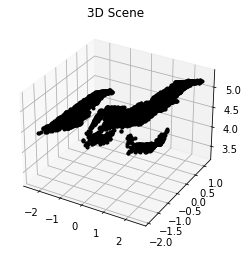

found 6114 points, 2719 unique points
Register image 0001.png from 2719 correspondences


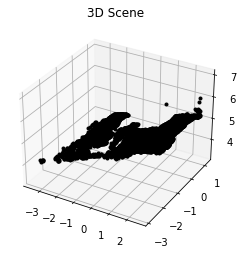

found 11663 points, 5300 unique points
Register image 0002.png from 5300 correspondences


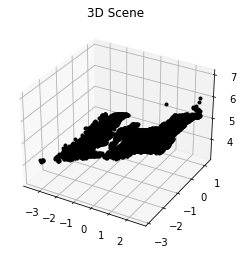

found 18103 points, 6565 unique points
Register image 0003.png from 6565 correspondences


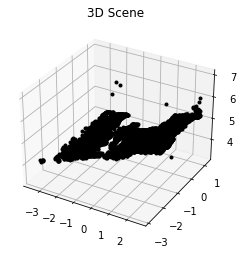

found 24205 points, 7266 unique points
Register image 0004.png from 7266 correspondences


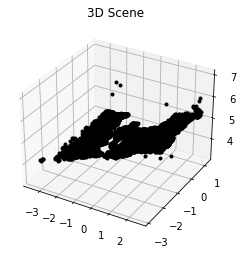

found 18929 points, 4822 unique points
Register image 0007.png from 4822 correspondences


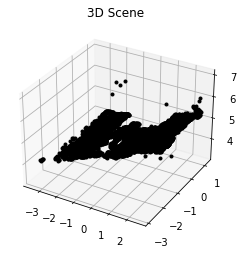

found 13648 points, 3763 unique points
Register image 0008.png from 3763 correspondences


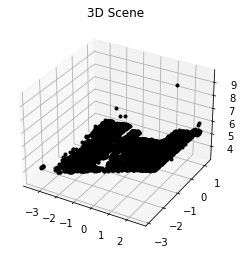

found 10113 points, 2801 unique points
Register image 0009.png from 2801 correspondences


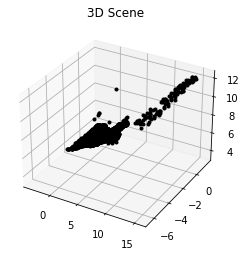

In [565]:
# Keep track of all registered images
registered_images = [e_im1_name, e_im2_name]

for reg_im in registered_images:
    print(f'Image {reg_im} sees {images[reg_im].NumObserved()} 3D points')

  # ------------------Map extension--------------------------------------
  # Register new images + triangulate
  # Run until we can register all images

while len(registered_images) < len(images):
    for image_name in images:
      if image_name in registered_images:
        continue

      # Find 2D-3D correspondences
      image_kp_idxs, point3D_idxs = Find2D3DCorrespondences(image_name, images, matches, registered_images)

      # With two few correspondences the pose estimation becomes shaky.
      # Keep this image for later
      if len(image_kp_idxs) < 50:
        continue

      print(f'Register image {image_name} from {len(image_kp_idxs)} correspondences')

      # Estimate new image pose
      R, t = EstimateImagePose(images[image_name].kps[image_kp_idxs], points3D[point3D_idxs], K)

      # Set the estimated image pose in the image and add the correspondences between keypoints and 3D points
      images[image_name].SetPose(R, t)
      images[image_name].Add3DCorrs(image_kp_idxs, point3D_idxs)

      
      # TODO
      # Triangulate new points wth all previously registered images
      image_points3D, corrs = TriangulateImage(K, image_name, images, registered_images, matches)
      # TODO
      # Update the 3D points and image correspondences
      points3D, images = UpdateReconstructionState(image_points3D, corrs, points3D, images)

      registered_images.append(image_name)
  
  
      # Visualize
      fig = plt.figure()
      ax3d = fig.add_subplot(111, projection='3d')
      Plot3DPoints(points3D, ax3d)
      PlotCameras(images, registered_images, ax3d)

      # Delay termination of the program until the figures are closed
      # Otherwise all figure windows will be killed with the program
      plt.show(block=True)

In [474]:
new_points3D, corrs, points3D, images = image_points3D, corrs, points3D, images

In [479]:
corrs

{<impl.sfm.image.Image at 0x7f9d2c73c6a0>: (array([4162, 3671, 1925,   58, 1955, 4867, 1873, 5812, 1821, 5252, 2254, 1884, 4717, 3740,  646, 1734, 1662, 4212, 4978, 7384, 4751, 6490, 7060, 5389, 5382, 3222, 6265, 7296, 6481, 3711, 3900, 3491, 6716, 6246, 6475, 4647, 5009, 2816, 7345, 4651, 2788, 6218, 5777, 7265,  253, 6725, 6619, 2106, 4738, 4737, 4750, 5915, 2435, 5780, 2743,   16, 4654, 4691, 2753,  201, 6990, 6927,  275, 5638, 2018,  560, 1279,   36,   30, 3139, 1717, 6201, 5541, 5092, 5948, 6491,  652,   21, 5696, 2766, 1603, 1150, 5983, 1869, 4150, 4576, 6921, 2715, 6878, 2794, 7430, 5695,   85, 7045,   67, 2637, 2759, 2837, 3832, 5409, 5848, 6097, 4298, 2463, 1307, 5683, 5671, 3308, 4812, 4561, 2740, 2263, 2776,   22, 4541,   74, 1556, 5440, 4679, 1421, 7306, 4868,   57, 1328, 2713, 4852, 2711, 7336, 2569, 2863, 1956, 2517,    5, 7093,  677, 2833, 2304, 5483, 5628, 5518, 1187, 4699, 4669, 6534, 2721,    0, 1195, 3713, 7388, 5221, 2754, 4726, 7092, 3563, 4290, 5592, 4291, 6492, 6

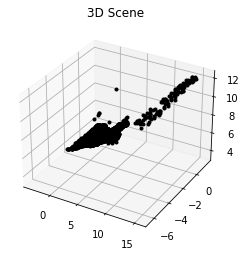

In [566]:
  # Visualize
  fig = plt.figure()
  ax3d = fig.add_subplot(111, projection='3d')
  Plot3DPoints(points3D, ax3d)
  PlotCameras(images, registered_images, ax3d)

  # Delay termination of the program until the figures are closed
  # Otherwise all figure windows will be killed with the program
  plt.show(block=True)

In [572]:
a = np.random.randn(3)
b = np.random.randn(3)

In [573]:
np.kron(a,b).shape

(12,)

In [476]:
  # TODO
  # Add the new points to the set of reconstruction points and add the correspondences to the images.
  # Be careful to update the point indices to the global indices in the `points3D` array.

  indx_shift = len(points3D)
  points3D = np.append(points3D, new_points3D, 0)

  for im_name in corrs:
    indx_start = indx_shift + corrs[im_name][1]
    indx_end  = indx_shift + corrs[im_name][2]
    images[im_name].Add3DCorrs(corrs[im_name][0], list(range(indx_start, indx_end)))

KeyError: <impl.sfm.image.Image object at 0x7f9d2c73c6a0>

In [477]:
images[]

KeyError: <impl.sfm.image.Image object at 0x7f9d2c73c6a0>

In [478]:
im_name

In [460]:
image_points3D.shape

(1058, 3)

In [441]:
points3D.shape

(1058, 3)

In [442]:
points3D_tmp.shape

(188, 3)

In [432]:
points3D_tmp.shape

(870, 3)

{}

In [ ]:
# Update the reconstruction with the new information from a triangulated image

new_points3D, corrs, points3D, images = image_points3D, corrs, points3D, images



In [422]:
kpsimg = image.kps[img_reg_match[:,0]]
kpsreg = regimg.kps[img_reg_match[:,1]]

In [426]:
points3D_tmp, img_corrs_tmp, reg_corrs_tmp = TriangulatePoints(K, image, regimg, img_reg_match)

In [428]:
img_corrs_tmp.shape

(870,)

In [429]:
reg_corrs_tmp.shape

(870,)

In [420]:
image.kps[img_reg_match[:,0]]

array([[2140.14, 1644.75],
       [2245.1 , 1381.86],
       [1572.43,  458.43],
       [1647.97,  313.67],
       [2221.9 , 1790.61],
       [1512.45,  994.32],
       [2250.33, 1259.23],
       [1816.96,  260.01],
       [1994.96, 1602.78],
       [1879.24, 1659.15],
       [1469.87, 1376.89],
       [1726.85,  257.83],
       [1729.04,  471.11],
       [2265.31, 1715.36],
       [1860.02, 1100.99],
       [1648.41,  159.36],
       [2318.08, 1882.67],
       [2014.74, 1469.47],
       [ 780.98, 1121.69],
       [2211.56, 1238.12],
       [1903.04, 1294.63],
       [2279.37, 1809.61],
       [1806.43,  945.38],
       [1765.43,  427.83],
       [2291.79, 1387.4 ],
       [ 850.58, 1803.88],
       [2154.76, 1203.73],
       [1923.22,  155.83],
       [2003.51, 1247.8 ],
       [2216.42, 1182.68],
       [1950.94,  639.68],
       [1784.14,  227.86],
       [1532.33, 1088.38],
       [2111.04,  493.89],
       [1650.95,  395.46],
       [2144.53, 1352.85],
       [2028.07, 1664.27],
 

In [419]:
img_reg_match[:,0]

array([1570, 1340, 1985,  328, 3347,  956, 1215, 1828, 3294, 3307, 4112,  260, 1991, 2722, 1038,  103, 4140, 1413, 1060, 3172, 1242, 1674,  906, 2902, 3231, 3735, 4103, 2801, 3866, 1132,  662, 1814, 2296,  534, 2896, 2465, 2667, 1076, 1827, 2890, 1183, 1919, 3410, 1032, 1161,  364, 3029, 1620, 3087, 1433, 1968, 3492,  903,  229,  369, 2605, 1189,  947, 1500, 1664, 4189,  410, 2323, 3102, 2475,  503, 2424, 2685, 1879, 2527, 2321, 1323, 1096, 3941, 1047, 3755, 1376, 2065,  523, 3061, 1802, 1143, 3250, 1108, 3822, 4227, 2934,  238, 3645, 3097, 1929, 3404, 3175, 3914, 1303, 2127, 2536, 1588,  535, 2188, ..., 3585, 1794, 3124, 3751, 1605, 4234, 2176,  178,  414,  680, 4031, 2586,  518, 2938, 2778, 1784, 2877, 3497, 1175, 1386, 1186, 1738, 2299, 3301, 2639, 1725, 2688,  852, 2388,  776,  435,  747, 1106, 2864, 1008, 3083,  853, 2264,   13, 4149,  464, 1010, 3053, 1611, 1068, 3579, 2857, 2933, 2402, 1343, 2790,  696,  466, 3966,  867, 3886, 3462, 1569, 3499, 1489,  898,  717, 1595, 1253, 2965

In [407]:
images

{'0000.png': <impl.sfm.image.Image at 0x7f9c1bb5f438>,
 '0001.png': <impl.sfm.image.Image at 0x7f9d2c710d68>,
 '0002.png': <impl.sfm.image.Image at 0x7f9c1b0c56d8>,
 '0003.png': <impl.sfm.image.Image at 0x7f9c1acbfa90>,
 '0004.png': <impl.sfm.image.Image at 0x7f9c1a3ae630>,
 '0005.png': <impl.sfm.image.Image at 0x7f9c1e938a58>,
 '0006.png': <impl.sfm.image.Image at 0x7f9c1caaf358>,
 '0007.png': <impl.sfm.image.Image at 0x7f9c1d308438>,
 '0008.png': <impl.sfm.image.Image at 0x7f9c1d391a90>,
 '0009.png': <impl.sfm.image.Image at 0x7f9c1d166f28>}

In [401]:
x = images[img]

In [404]:
images

{'0000.png': <impl.sfm.image.Image at 0x7f9c1bb5f438>,
 '0001.png': <impl.sfm.image.Image at 0x7f9d2c710d68>,
 '0002.png': <impl.sfm.image.Image at 0x7f9c1b0c56d8>,
 '0003.png': <impl.sfm.image.Image at 0x7f9c1acbfa90>,
 '0004.png': <impl.sfm.image.Image at 0x7f9c1a3ae630>,
 '0005.png': <impl.sfm.image.Image at 0x7f9c1e938a58>,
 '0006.png': <impl.sfm.image.Image at 0x7f9c1caaf358>,
 '0007.png': <impl.sfm.image.Image at 0x7f9c1d308438>,
 '0008.png': <impl.sfm.image.Image at 0x7f9c1d391a90>,
 '0009.png': <impl.sfm.image.Image at 0x7f9c1d166f28>}

In [405]:
matches[(img,'0001.png')]

array([[2208, 2922],
       [  93,   71],
       [3629, 4945],
       [2951, 4005],
       [ 229, 2395],
       [4023, 5480],
       [2221, 4165],
       [2896, 3924],
       [4091, 5589],
       [ 428,  435],
       [1142, 1498],
       [3834, 5433],
       [ 902, 2948],
       [ 126, 2270],
       [1571, 2062],
       [ 324,  392],
       [ 278,  333],
       [3239, 4403],
       [1153, 1535],
       [ 258, 2401],
       [2647, 3559],
       [1753, 2342],
       [3871, 5248],
       [ 487,  602],
       [3199, 3283],
       [2765, 3711],
       [1216, 1590],
       [1762, 2331],
       [1184, 3208],
       [4034, 5504],
       [1506, 3514],
       [1597, 2105],
       [3698, 5042],
       [3313, 4515],
       [ 363,  368],
       [ 136, 2247],
       [1715, 2279],
       [3261, 4433],
       [ 694,  842],
       [3819, 5193],
       [2517, 3389],
       [1870, 2404],
       [3329, 4532],
       [2792, 3766],
       [2669, 4511],
       [2509, 3377],
       [3701, 5045],
       [ 591,

array([ 8.192,  2.158, -4.203])

In [352]:
points2D, points3D, K = images[image_name].kps[image_kp_idxs], points3D[point3D_idxs], K

In [ ]:
K, image_name, images, registered_images, matches

# def TriangulateImage(K, image_name, images, registered_images, matches):

  # TODO 
  # Loop over all registered images and triangulate new points with the new image.
  # Make sure to keep track of all new 2D-3D correspondences, also for the registered images

  image = images[image_name]
  points3D = np.zeros((0,3))
  # You can save the correspondences for each image in a dict and refer to the `local` new point indices here.
  # Afterwards you just add the index offset before adding the correspondences to the images.
  corrs = {}
  
#   return points3D, corrs

In [359]:
t

array([ 8.192,  2.158, -4.203])

In [ ]:
r,t = possible_relative_poses[3]

r1, t1 = np.identity(r.shape[0]), np.zeros_like(t)
e_im1.SetPose(r1, t1) # identity rotation, no translation -> assumed origin
e_im2.SetPose(r, t)

In [290]:
# parameters
im1 = e_im1
im2 = e_im2

# def TriangulatePoints(K, im1, im2, matches):
R1, t1 = im1.Pose()
R2, t2 = im2.Pose()
P1 = K @ np.append(R1, np.expand_dims(t1, 1), 1)
P2 = K @ np.append(R2, np.expand_dims(t2, 1), 1)

# Ignore matches that already have a triangulated point
new_matches = np.zeros((0, 2), dtype=int)

num_matches = matches.shape[0]
for i in range(num_matches):
  p3d_idx1 = im1.GetPoint3DIdx(matches[i, 0])
  p3d_idx2 = im2.GetPoint3DIdx(matches[i, 1])
  if p3d_idx1 == -1 and p3d_idx2 == -1:
    new_matches = np.append(new_matches, matches[[i]], 0)


num_new_matches = new_matches.shape[0]

points3D = np.zeros((num_new_matches, 3))

for i in range(num_new_matches):

  kp1 = im1.kps[new_matches[i, 0], :]
  kp2 = im2.kps[new_matches[i, 1], :]

  # H & Z Sec. 12.2
  A = np.array([
    kp1[0] * P1[2] - P1[0],
    kp1[1] * P1[2] - P1[1],
    kp2[0] * P2[2] - P2[0],
    kp2[1] * P2[2] - P2[1]
  ])

  _, _, vh = np.linalg.svd(A)
  homogeneous_point = vh[-1]
  points3D[i] = homogeneous_point[:-1] / homogeneous_point[-1]


# We need to keep track of the correspondences between image points and 3D points
im1_corrs = new_matches[:,0]
im2_corrs = new_matches[:,1]

In [ ]:
points3D_homo = MakeHomogeneous(points3D, ax=1)
proj_cam1 = points3D_homo @ P1.T
proj_cam2 = points3D_homo @ P2.T


mask_cam1 = proj_cam1[:,2]>0
mask_cam2 = proj_cam2[:,2]>0


# Filter points behind the first camera
im1_corrs = im1_corrs[mask_cam1]
im2_corrs = im2_corrs[mask_cam1]
points3D = points3D[mask_cam1]

# Filter points behind the second camera
im1_corrs = im1_corrs[mask_cam2]
im2_corrs = im2_corrs[mask_cam2]
points3D = points3D[mask_cam1]



In [ ]:
proj_cam2

In [ ]:
print(points3D_homo.shape)
print(P1.shape)
print(proj_cam1.shape)

In [ ]:
points3D.shape

In [ ]:
im2_corrs.shape

In [ ]:
points3D.shape

In [ ]:
points3D>0

In [ ]:
points3D

In [ ]:
im2_corrs.shape

In [ ]:
matches[('0000.png', '0001.png')].shape

In [ ]:
matches[('0000.png', '0002.png')].shape

In [ ]:
K

In [ ]:
def main():

  np.set_printoptions(linewidth=10000, edgeitems=100, precision=3)

  data_folder = '../data'
  image_names = [
    '0000.png',
    '0001.png',
    '0002.png',
    '0003.png',
    '0004.png',
    '0005.png',
    '0006.png',
    '0007.png',
    '0008.png',
    '0009.png']

  # Read images
  images = {}
  for im_name in image_names:
    images[im_name] = (Image(data_folder, im_name))

  # Read the matches
  matches = {}
  for image_pair in itertools.combinations(image_names, 2):
    matches[image_pair] = ReadFeatureMatches(image_pair, data_folder)

  K = ReadKMatrix(data_folder)

  # init_images = [3, 4]
  init_images = [5, 6]

  # ------------------------------------------------------------------------------------
  # Visualize images and features
  # You can comment these lines once you verified that the images are loaded correctly

  # Show the images
  PlotImages(images)

  # Show the keypoints
  for image_name in image_names:
    PlotWithKeypoints(images[image_name])

  # Show the feature matches
  for image_pair in itertools.combinations(image_names, 2):
    PlotImagePairMatches(images[image_pair[0]], images[image_pair[1]], matches[(image_pair[0], image_pair[1])])
    gc.collect()
  # ------------------------------------------------------------------------------------
  
  e_im1_name = image_names[init_images[0]]
  e_im2_name = image_names[init_images[1]]
  e_im1 = images[e_im1_name]
  e_im2 = images[e_im2_name]
  e_matches = GetPairMatches(e_im1_name, e_im2_name, matches)

  # TODO Estimate relative pose of first pair
  # Estimate Fundamental matrix
  E = EstimateEssentialMatrix(K, e_im1, e_im2, e_matches)

  # Extract the relative pose from the essential matrix.
  # This gives four possible solutions and we need to check which one is the correct one in the next step
  possible_relative_poses = DecomposeEssentialMatrix(E)


  # ------------------Finding the correct decomposition--------------------------------------
  # For each possible relative pose, try to triangulate points with function TriangulatePoints.
  # We can assume that the correct solution is the one that gives the most points in front of both cameras.
  max_points = 0
  best_pose = -1
  # Be careful not to set the transformation in the wrong direction
  # you can set the image poses in the images (image.SetPose(...))
  # Note that this pose is assumed to be the transformation from global space to image space
  # TODO
  

  # TODO
  # Set the image poses in the images (image.SetPose(...))
  # Note that the pose is assumed to be the transformation from global space to image space
  e_im1.SetPose(...)
  e_im2.SetPose(...)


  # Triangulate initial points
  points3D, im1_corrs, im2_corrs = TriangulatePoints(K, e_im1, e_im2, e_matches)

  # Add the new 2D-3D correspondences to the images
  e_im1.Add3DCorrs(im1_corrs, list(range(points3D.shape[0])))
  e_im2.Add3DCorrs(im2_corrs, list(range(points3D.shape[0])))

  # Keep track of all registered images
  registered_images = [e_im1_name, e_im2_name]

  for reg_im in registered_images:
    print(f'Image {reg_im} sees {images[reg_im].NumObserved()} 3D points')

  # ------------------Map extension--------------------------------------
  # Register new images + triangulate
  # Run until we can register all images
  while len(registered_images) < len(images):
    for image_name in images:
      if image_name in registered_images:
        continue

      # Find 2D-3D correspondences
      image_kp_idxs, point3D_idxs = Find2D3DCorrespondences(image_name, images, matches, registered_images)

      # With two few correspondences the pose estimation becomes shaky.
      # Keep this image for later
      if len(image_kp_idxs) < 50:
        continue

      print(f'Register image {image_name} from {len(image_kp_idxs)} correspondences')

      # Estimate new image pose
      R, t = EstimateImagePose(images[image_name].kps[image_kp_idxs], points3D[point3D_idxs], K)

      # Set the estimated image pose in the image and add the correspondences between keypoints and 3D points
      images[image_name].SetPose(R, t)
      images[image_name].Add3DCorrs(image_kp_idxs, point3D_idxs)

      # TODO
      # Triangulate new points wth all previously registered images
      image_points3D, corrs = TriangulateImage(K, image_name, images, registered_images, matches)

      # TODO
      # Update the 3D points and image correspondences
      points3D, images = UpdateReconstructionState(image_points3D, corrs, points3D, images)

      registered_images.append(image_name)


  # Visualize
  fig = plt.figure()
  ax3d = fig.add_subplot(111, projection='3d')
  Plot3DPoints(points3D, ax3d)
  PlotCameras(images, registered_images, ax3d)

  # Delay termination of the program until the figures are closed
  # Otherwise all figure windows will be killed with the program
  plt.show(block=True)